In [2]:
import numpy as np
import sys
sys.path.append("../")

In [3]:
from Utils.CustomFunctions import Train_Classifiers

# Classic ML

## Efficient Net

In [3]:
x = np.load("../Data/Images/Image Embeddings/EfficientNet.npy")
y = np.load("../Data/Text/TF-IDF/labels.npy")

In [4]:
models = Train_Classifiers(x, y)

In [5]:
models.fit()

Training Logistic Regression
Logistic Regression Model Trained
Time taken = 1.42 seconds
------------------
Training Decision Tree
Decision Tree Model Trained
Time taken = 20.33 seconds
------------------
Training KNN
KNN Model Trained
Time taken = 0.004 seconds
------------------
Training Multinomial Naive Bayes
Model Skipped
------------------
Training Gaussian Naive Bayes
Gaussian Naive Bayes Model Trained
Time taken = 0.041 seconds
------------------
Training SVC
SVC Model Trained
Time taken = 16.489 seconds
------------------
Training AdaBoost
AdaBoost Model Trained
Time taken = 81.284 seconds
------------------
Training Random Forest
Random Forest Model Trained
Time taken = 36.057 seconds
------------------
Training XGBoost
XGBoost Model Trained
Time taken = 122.198 seconds
------------------
Training CatBoost
Learning rate set to 0.085654
0:	learn: 1.0944891	total: 238ms	remaining: 3m 57s
1:	learn: 1.0895990	total: 289ms	remaining: 2m 24s
2:	learn: 1.0853534	total: 336ms	remaini

In [6]:
models.score()

Logistic Regression: 0.3860369609856263
Decision Tree: 0.39014373716632444
KNN: 0.36344969199178645
Gaussian Naive Bayes: 0.4055441478439425
SVC: 0.43737166324435317
AdaBoost: 0.4106776180698152
Random Forest: 0.4342915811088296
XGBoost: 0.4271047227926078
CatBoost: 0.4414784394250513
LightGBM: 0.4075975359342916


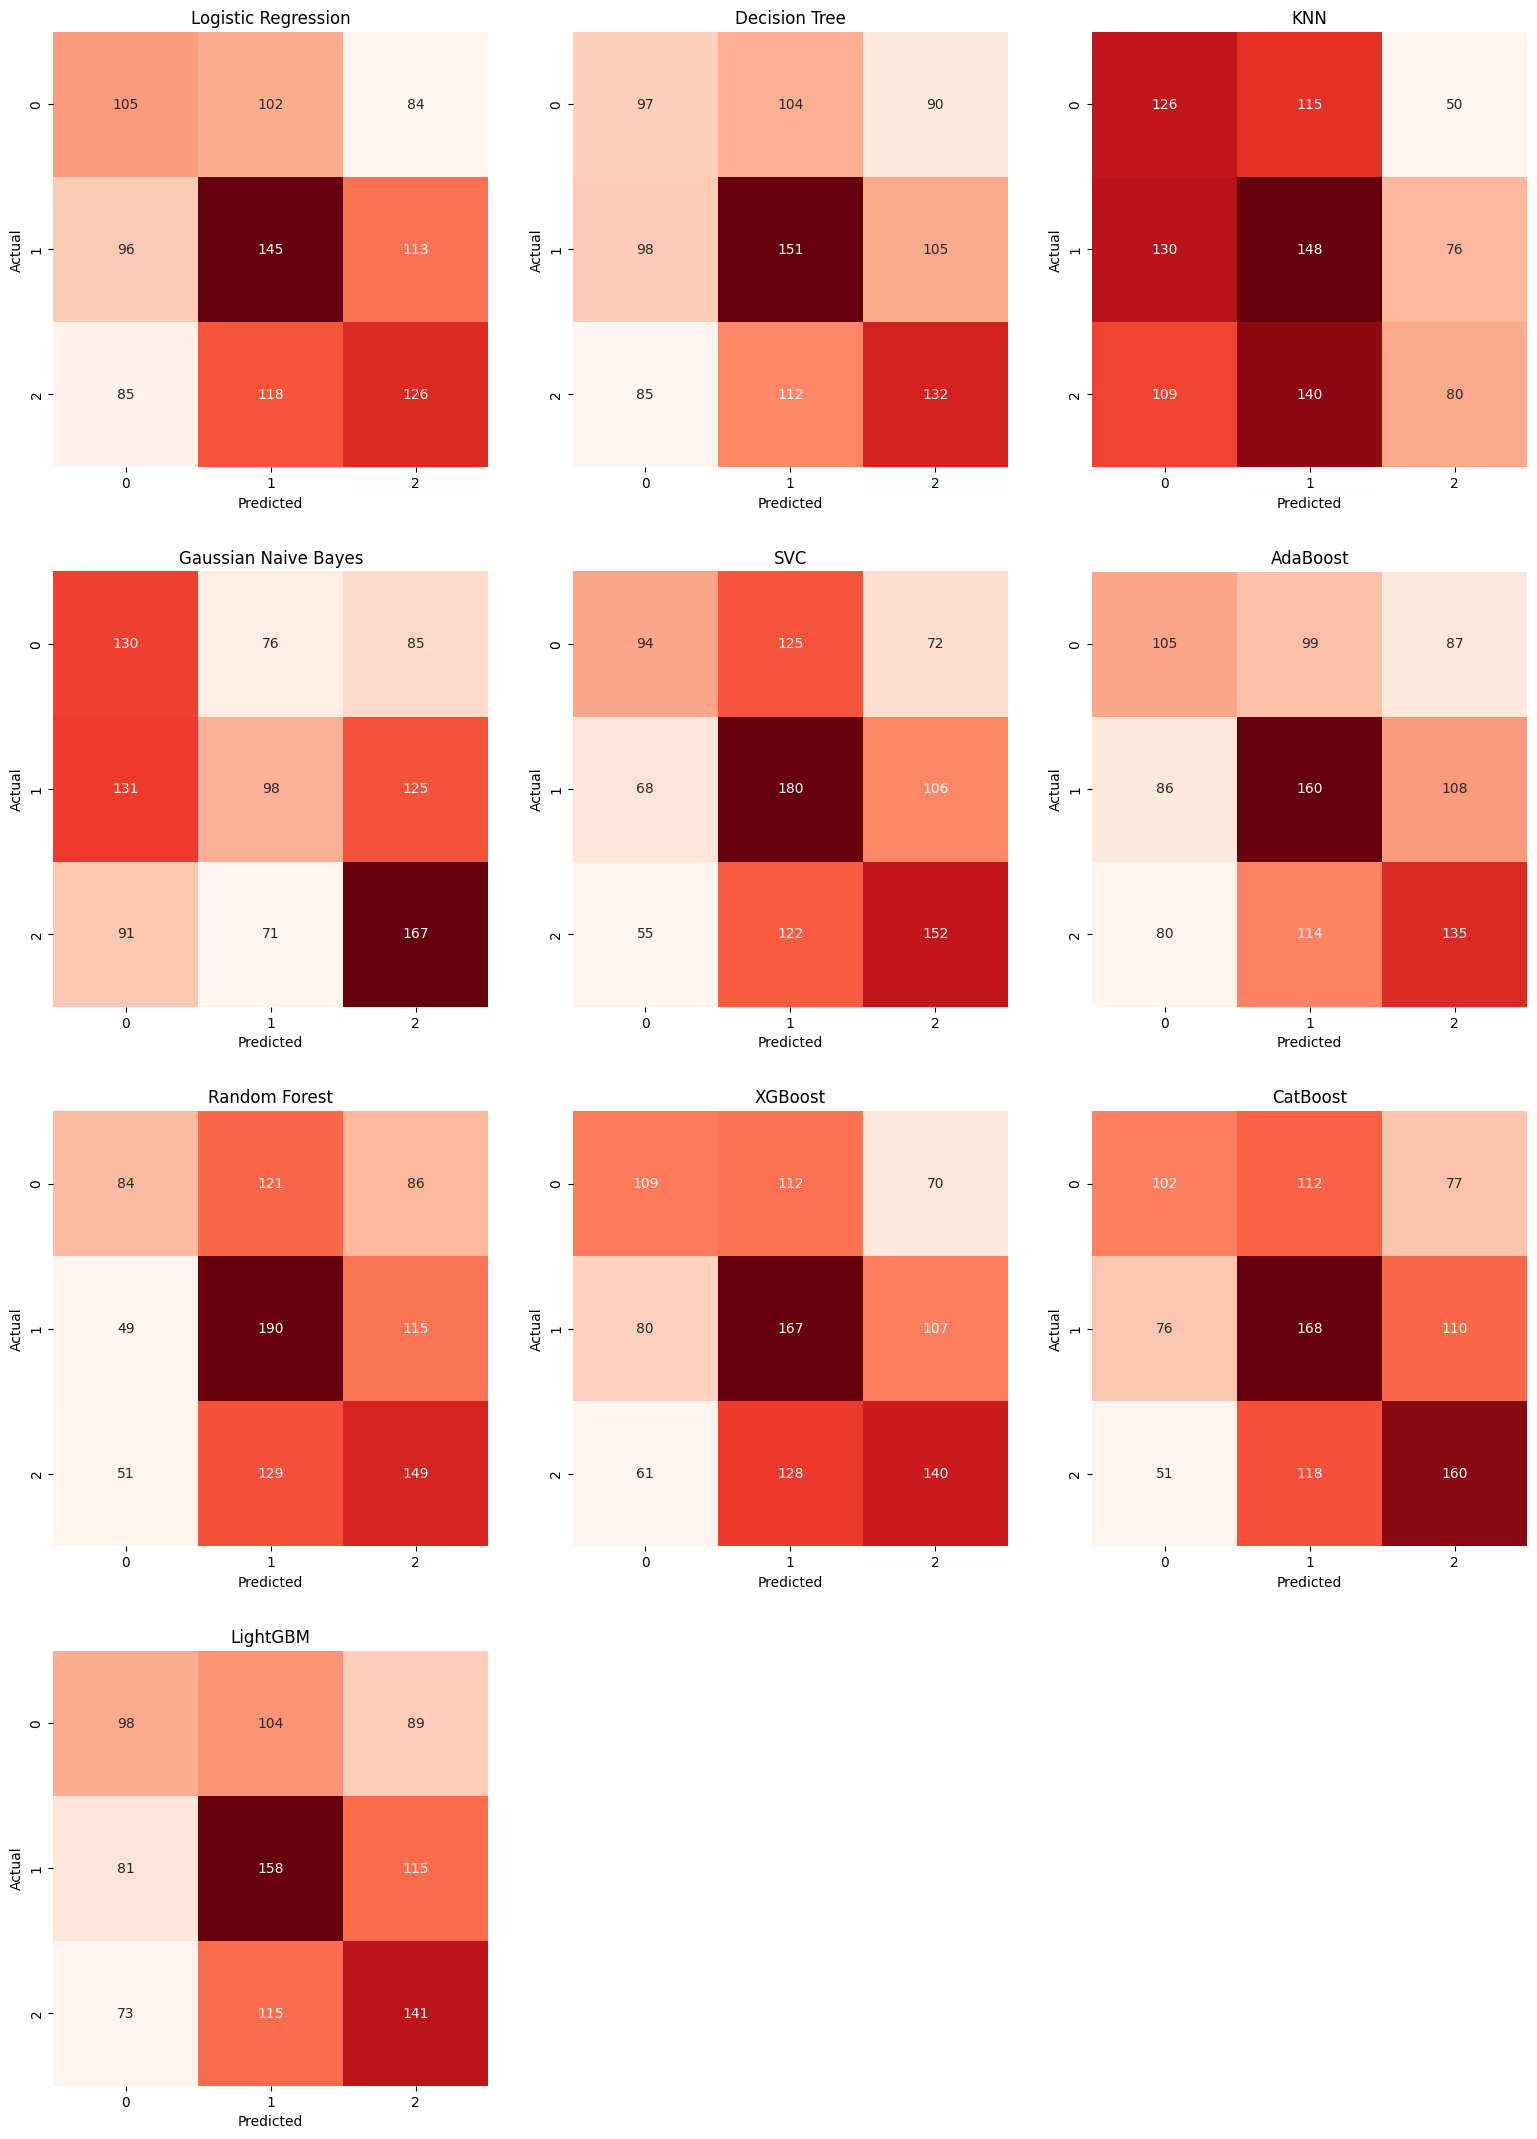

In [7]:
models.Compare_ConfusionMatrices()

In [8]:
models.Compare_Performance()

,Name,Accuracy,AUC,Precision_0,Precision_1,Precision_2,Recall_0,Recall_1,Recall_2,f1-score_0,f1-score_1,f1-score_2
0,Logistic Regression,0.386,0.568,0.367,0.397,0.390,0.361,0.410,0.383,0.364,0.403,0.387
1,Decision Tree,0.390,0.540,0.346,0.411,0.404,0.333,0.427,0.401,0.340,0.419,0.402
2,KNN,0.363,0.545,0.345,0.367,0.388,0.433,0.418,0.243,0.384,0.391,0.299
3,Gaussian Naive Bayes,0.406,0.581,0.369,0.400,0.443,0.447,0.277,0.508,0.404,0.327,0.473
4,SVC,0.437,NaN,0.433,0.422,0.461,0.323,0.508,0.462,0.370,0.461,0.461
5,AdaBoost,0.411,0.556,0.387,0.429,0.409,0.361,0.452,0.410,0.374,0.440,0.410
6,Random Forest,0.434,0.618,0.457,0.432,0.426,0.289,0.537,0.453,0.354,0.479,0.439
7,XGBoost,0.427,0.616,0.436,0.410,0.442,0.375,0.472,0.426,0.403,0.439,0.433
8,CatBoost,0.441,0.619,0.445,0.422,0.461,0.351,0.475,0.486,0.392,0.447,0.473
9,LightGBM,0.408,0.614,0.389,0.419,0.409,0.337,0.446,0.429,0.361,0.432,0.418


In [9]:
lgbm = models.get_single_model('LightGBM')

In [10]:
lgbm.predict_proba(x).shape

(4869, 3)

## Denset Net

In [7]:
x = np.load("../Data/Images/Image Embeddings/densenet.npy")
y = np.load("../Data/Text/TF-IDF/labels.npy")

In [11]:
x = x.reshape(4869, 1664)

In [12]:
models = Train_Classifiers(x, y)

In [13]:
models.fit()

Training Logistic Regression
Logistic Regression Model Trained
Time taken = 1.441 seconds
------------------
Training Decision Tree
Decision Tree Model Trained
Time taken = 38.157 seconds
------------------
Training KNN
KNN Model Trained
Time taken = 0.01 seconds
------------------
Training Multinomial Naive Bayes
Multinomial Naive Bayes Model Trained
Time taken = 0.049 seconds
------------------
Training Gaussian Naive Bayes
Gaussian Naive Bayes Model Trained
Time taken = 0.084 seconds
------------------
Training SVC
SVC Model Trained
Time taken = 33.106 seconds
------------------
Training AdaBoost
AdaBoost Model Trained
Time taken = 216.65 seconds
------------------
Training Random Forest
Random Forest Model Trained
Time taken = 97.267 seconds
------------------
Training XGBoost
XGBoost Model Trained
Time taken = 212.806 seconds
------------------
Training CatBoost
Learning rate set to 0.085654
0:	learn: 1.0928084	total: 484ms	remaining: 8m 3s
1:	learn: 1.0870166	total: 557ms	remaini

In [14]:
models.score()

Logistic Regression: 0.3788501026694045
Decision Tree: 0.39117043121149897
KNN: 0.39117043121149897
Multinomial Naive Bayes: 0.3675564681724846
Gaussian Naive Bayes: 0.3726899383983573
SVC: 0.41581108829568786
AdaBoost: 0.35728952772073924
Random Forest: 0.4188911704312115
XGBoost: 0.43634496919917864
CatBoost: 0.433264887063655
LightGBM: 0.4353182751540041


In [15]:
models.Compare_Performance()

,Name,Accuracy,AUC,Precision_0,Precision_1,Precision_2,Recall_0,Recall_1,Recall_2,f1-score_0,f1-score_1,f1-score_2
0,Logistic Regression,0.379,0.543,0.311,0.391,0.428,0.313,0.398,0.416,0.312,0.394,0.422
1,Decision Tree,0.391,0.542,0.374,0.408,0.388,0.371,0.412,0.386,0.372,0.410,0.387
2,KNN,0.391,0.564,0.339,0.408,0.461,0.454,0.452,0.271,0.388,0.429,0.341
3,Multinomial Naive Bayes,0.368,0.556,0.316,0.393,0.391,0.344,0.339,0.419,0.329,0.364,0.405
4,Gaussian Naive Bayes,0.373,0.562,0.344,0.401,0.380,0.426,0.314,0.389,0.381,0.352,0.384
5,SVC,0.416,NaN,0.374,0.415,0.441,0.265,0.492,0.468,0.310,0.450,0.454
6,AdaBoost,0.357,0.545,0.344,0.368,0.355,0.309,0.421,0.331,0.325,0.393,0.343
7,Random Forest,0.419,0.615,0.413,0.410,0.436,0.268,0.545,0.416,0.325,0.468,0.426
8,XGBoost,0.436,0.614,0.457,0.432,0.428,0.361,0.525,0.407,0.403,0.474,0.417
9,CatBoost,0.433,0.628,0.417,0.437,0.440,0.330,0.508,0.444,0.369,0.470,0.442


# CNN

In [1]:
from torchvision.models.efficientnet import efficientnet_b1, EfficientNet_B1_Weights, efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
data = pd.read_csv("../Data/Images/ImageLabelsSequenced.csv")

In [6]:
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)

In [7]:
num_classes = 3
    
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1280, out_features=num_classes)
)

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)

In [9]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['LABEL'])
train, val = train_test_split(train, test_size=0.125, shuffle=True, stratify=train['LABEL'])

In [10]:
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, filename, labels, transform) -> None:
        super().__init__()
        self.img_dir = img_dir
        self.filename = filename
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.filename[index])
        image = Image.open(img_path)
        image = image.convert("RGB")
        image = self.transform(image)
        label = torch.tensor(self.labels[index])
        return (image, label)
    
train_set = CustomImageDataset("../Data/Images", np.array(train['File Name']), np.array(train['LABEL']), weights.transforms())
val_set = CustomImageDataset("../Data/Images", np.array(val['File Name']), np.array(val['LABEL']), weights.transforms())

In [11]:
train_loader = DataLoader(train_set, 16)
val_loader = DataLoader(val_set, 16)

In [9]:
from tqdm.notebook import tqdm
def TrainLoopCompact(
    model,
    optimizer:torch.optim.Optimizer,
    criterion:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    val_dataloader:torch.utils.data.DataLoader,
    scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau,
    num_epochs:int=20,
    early_stopping_rounds:int=5,
    return_best_model:bool=True,
    device:str='cpu'
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_weights = model.state_dict()

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print("\nEpoch {}\n----------".format(epoch))
        train_loss = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss
            loss.backward()
            optimizer.step()
            print("Loss for batch {} = {}".format(i, loss))

        print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))

        model.eval()
        validation_loss = 0
        with torch.inference_mode():
            for (images, labels) in val_dataloader:
                images = images.to(device)
                labels = labels.to(device, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss

            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_without_improvement = 0
                best_model_weights = model.state_dict()
            else:
                epochs_without_improvement += 1

            print(f"Current Validation Loss = {validation_loss}")
            print(f"Best Validation Loss = {best_val_loss}")
            print(f"Epochs without Improvement = {epochs_without_improvement}")
        scheduler.step(validation_loss)
        if epochs_without_improvement == early_stopping_rounds:
            break

    if return_best_model == True:
        model.load_state_dict(best_model_weights)

In [ ]:
TrainLoopCompact(model, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 15, device='cuda')